In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import scipy
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
norm_dict = {0: [2.3, 0.24], 1: [2.29, 0.22], 2: [2.29, 0.23], 3: [2.31, 0.24], 4: [2.31, 0.24], 
             5: [2.32, 0.24], 6: [2.29, 0.26], 7: [2.29, 0.28], 8: [2.32, 0.23], 9: [2.33, 0.24], 
             10: [2.28, 0.21], 11: [2.33, 0.25], 12: [2.32, 0.22], 13: [2.31, 0.22], 14: [2.29, 0.29], 
             15: [2.28, 0.2], 16: [2.3, 0.27], 17: [2.31, 0.22], 18: [2.3, 0.22], 19: [2.28, 0.19]}

In [3]:
def add_restype(df):
    for index, row in df.iterrows():
        info = row[0]
        res_type = df_expt[df_expt['info'] == info].Res_Name.values[0]
        df.loc[index, 'Res_Name'] = res_type

In [4]:
model_pka_dict = {'ASP': 3.7, 'GLU': 4.2, 'HIS': 6.5, 'CYS': 8.5, 'LYS': 10.4, 'TYR': 10.1}
def back_to_pka(df):
    for index, row in df.iterrows():
        res_type = row['Res_Name']
        dpka = row['pred_dpka_an']
        #expt = row['expt']
        pred_pka = dpka + model_pka_dict[res_type]
        #expt_pka = expt + model_pka_dict[res_type]
        df.loc[index, 'pred_pka_an'] = pred_pka
        #df.loc[index, 'expt_pka'] = expt_pka

In [43]:
def anti_norm(df, std, mean):
    for index, row in df.iterrows():
        info = row[0]
        df.at[index, 'Expt_pKa'] = df_expt[df_expt['info'] == info]['Expt_pKa'].values[0]
        df.at[index, 'Expt_dpKa'] = df_expt[df_expt['info'] == info]['d_pka'].values[0]
        df.at[index, 'd_pka'] = df_expt[df_expt['info'] == info]['d_pka'].values[0]
    df['pred_dpka_an'] = (df['pred'] * std) + mean

In [6]:
def anti_norm_dtl(df, std, mean):
    df['pred_dpka_an'] = (df['pred'] * std) + mean
    df['expt_dpka_an'] = (df['expt'] * std) + mean

In [7]:
def drop_cphmd_cys(df, n_expt):
    df3 = pd.DataFrame()
    df1 = df[df['Res_Name'] != 'CYS']
    df2 = df[df['Res_Name'] == 'CYS']
    tmp = pd.read_csv(f'/home/rotation/mingzhe/his_pka/split_restype_v3/expt{n_expt}_test.csv')
    tmp = tmp[(tmp['Res_Name'] == 'CYS') & (tmp['tag'] == 'expt')]
    for index, row in df2.iterrows():
        info = row['info']
        if info in tmp['info'].unique():
            df3 = pd.concat([df3, df2.loc[[index]]], ignore_index = True)
    df = pd.concat([df1, df3], ignore_index = True)
    return df

In [8]:
def make_ensamble(n_expt):
    ensemble_li = []
    for fold in range(10):
        if os.path.isfile(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_predictions.csv'):
            df = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_predictions.csv')
            add_restype(df)
            anti_norm(df, norm_dict[n_expt][0], norm_dict[n_expt][1])
            back_to_pka(df)
            df.rename({'0': 'info'}, axis=1, inplace=True)
            rf_result = drop_cphmd_cys(df, n_expt)
            rmse = round(((rf_result.d_pka - rf_result.pred_dpka_an) ** 2).mean() ** 0.5, 2)
            if rmse <= 1.2:
                ensemble_li.append(f'pred{fold}')
    return ensemble_li

In [9]:
def ensamble_result(n_expt, ensemble_li):
    tmp0 = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f0_predictions.csv')
    rf_result = tmp0.copy()
    rf_result.columns = ['info', 'expt', 'pred0']
    for fold in range(1, 10):
        if os.path.isfile(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_predictions.csv'):
            tmp = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_predictions.csv')
            rf_result[f'pred{fold}'] = tmp['pred']
    #rf_result['pred'] = rf_result.loc[:, ['pred0', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'pred6', 'pred7', 'pred8', 'pred9']].mean(axis = 1)
    rf_result['pred'] = rf_result.loc[:, ensemble_li].mean(axis = 1)
    return rf_result

In [10]:
df_expt = pd.read_csv('/home/rotation/mingzhe/his_pka/regression/split_restype_v2_stded_dpka.dat')

# train_val

In [16]:
df_metrics_train = pd.DataFrame()
for n_expt in range(20):
    for fold in range(10):
        if os.path.isfile(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_traindtl.csv'):
            df_traindtl = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_traindtl.csv')
            anti_norm_dtl(df_traindtl, norm_dict[n_expt][0], norm_dict[n_expt][1])
            df_valdtl = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_valdtl.csv')
            anti_norm_dtl(df_valdtl, norm_dict[n_expt][0], norm_dict[n_expt][1])
            df_test = pd.read_csv(f'REG_GAT_exptFv32_sphere_sgkf_selftest_graphein_arl_E{n_expt}f{fold}_predictions.csv')
            add_restype(df_test)
            anti_norm_dtl(df_test, norm_dict[n_expt][0], norm_dict[n_expt][1])
            back_to_pka(df_test)
            df_test.rename({'0': 'info'}, axis=1, inplace=True)
            df_test = drop_cphmd_cys(df_test, n_expt)
            
            train = round(((df_traindtl.expt_dpka_an - df_traindtl.pred_dpka_an) ** 2).mean() ** 0.5, 2)
            train_pcc = round(df_traindtl['expt_dpka_an'].corr(df_traindtl['pred_dpka_an']), 2)
            val = round(((df_valdtl.expt_dpka_an - df_valdtl.pred_dpka_an) ** 2).mean() ** 0.5, 2)
            val_pcc = round(df_valdtl['expt_dpka_an'].corr(df_valdtl['pred_dpka_an']), 2)
            test = round(((df_test.expt_dpka_an - df_test.pred_dpka_an) ** 2).mean() ** 0.5, 2)
            test_pcc = round(df_test['expt_dpka_an'].corr(df_test['pred_dpka_an']), 2)
            
            tmp_li = {'Expt': [n_expt], 'fold': [fold], 
                      'train_rmse': [train], 'train_pcc': [train_pcc], 
                      'val_rmse': [val], 'val_pcc': [val_pcc],
                      'test_rmse': [test], 'test_pcc': [test_pcc]}
            tmp = pd.DataFrame(tmp_li)
            df_metrics_train = pd.concat([df_metrics_train, tmp], ignore_index = True) 

In [40]:
### all the PCC here is for the d_pka
df_metrics_train.loc['mean'] = df_metrics_train.head(200).mean()
df_metrics_train.loc['std'] = df_metrics_train.head(200).std()
df_metrics_train.round(2).tail(2)

Expt  fold  train_rmse  train_pcc  val_rmse  val_pcc  test_rmse  \
mean  9.51  4.52        0.98       0.90      1.34     0.79       1.03   
std   5.77  2.90        0.15       0.07      0.24     0.10       0.13   

      test_pcc  
mean      0.64  
std       0.08

# regression

In [41]:
rf_result.head(2)

info Res_Name  Expt_pKa  pred_dpka_an  pred_pka_an
0  135L-A-87      ASP      2.13     -0.837294     2.862706
1  1A2P-A-75      ASP      3.10      1.546234     5.246234

In [45]:
df_metrics_reg = pd.DataFrame()
for n_expt in range(20):
    df_train = pd.read_csv(f'/home/rotation/mingzhe/his_pka/split_restype_v3/expt{n_expt}f0_train_10.csv')
    len_asp = len(df_train[df_train['Res_Name'] == 'ASP'].infor.unique())
    len_glu = len(df_train[df_train['Res_Name'] == 'GLU'].infor.unique())
    len_his = len(df_train[df_train['Res_Name'] == 'HIS'].infor.unique())
    len_cys = len(df_train[df_train['Res_Name'] == 'CYS'].infor.unique())
    len_tyr = len(df_train[df_train['Res_Name'] == 'TYR'].infor.unique())
    len_lys = len(df_train[df_train['Res_Name'] == 'LYS'].infor.unique())
    ensemble_li = make_ensamble(n_expt)
    rf_result = ensamble_result(n_expt, ensemble_li)
    add_restype(rf_result)
    anti_norm(rf_result, norm_dict[n_expt][0], norm_dict[n_expt][1])
    back_to_pka(rf_result)
    rf_result = drop_cphmd_cys(rf_result, n_expt)
    maxe = abs(rf_result['Expt_pKa'] - rf_result['pred_pka_an']).max()
    rmse = round(((rf_result.Expt_pKa - rf_result.pred_pka_an) ** 2).mean() ** 0.5, 2)
    pcc = round(rf_result['Expt_pKa'].corr(rf_result['pred_pka_an']), 2)
    pcc_dpka = round(rf_result['Expt_dpKa'].corr(rf_result['pred_dpka_an']), 2)
    df_asp = rf_result[rf_result['Res_Name'] == 'ASP']
    rmse_asp = round(((df_asp.Expt_pKa - df_asp.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_asp = scipy.stats.linregress(df_asp['Expt_pKa'], df_asp['pred_pka_an']).rvalue
    df_glu = rf_result[rf_result['Res_Name'] == 'GLU']
    rmse_glu = round(((df_glu.Expt_pKa - df_glu.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_glu = scipy.stats.linregress(df_glu['Expt_pKa'], df_glu['pred_pka_an']).rvalue
    df_his = rf_result[rf_result['Res_Name'] == 'HIS']
    rmse_his = round(((df_his.Expt_pKa - df_his.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_his = scipy.stats.linregress(df_his['Expt_pKa'], df_his['pred_pka_an']).rvalue
    df_cys = rf_result[rf_result['Res_Name'] == 'CYS']
    rmse_cys = round(((df_cys.Expt_pKa - df_cys.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_cys = scipy.stats.linregress(df_cys['Expt_pKa'], df_cys['pred_pka_an']).rvalue
    df_lys = rf_result[rf_result['Res_Name'] == 'LYS']
    rmse_lys = round(((df_lys.Expt_pKa - df_lys.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_lys = scipy.stats.linregress(df_lys['Expt_pKa'], df_lys['pred_pka_an']).rvalue
    df_tyr = rf_result[rf_result['Res_Name'] == 'TYR']
    rmse_tyr = round(((df_tyr.Expt_pKa - df_tyr.pred_pka_an) ** 2).mean() ** 0.5, 2)
    r_tyr = scipy.stats.linregress(df_tyr['Expt_pKa'], df_tyr['pred_pka_an']).rvalue
    tmp_li = {'Expt': [n_expt], 'rmse': [rmse], 'pcc': [pcc], 'pcc_dpka': [pcc_dpka], 'maxe': [maxe],
              'rmse_asp': [rmse_asp], 'pcc_asp': [r_asp], 'rmse_glu': [rmse_glu], 'pcc_glu': [r_glu],
              'rmse_his': [rmse_his], 'pcc_his': [r_his], 'rmse_cys': [rmse_cys], 'pcc_cys': [r_cys],
              'rmse_tyr': [rmse_tyr], 'pcc_tyr': [r_tyr], 'rmse_lys': [rmse_lys], 'pcc_lys': [r_lys],
              'n_asp': [len_asp], 'n_glu': [len_glu], 'n_his': [len_his],
              'n_cys': [len_cys], 'n_tyr': [len_tyr], 'n_lys': [len_lys]}
    tmp = pd.DataFrame(tmp_li)
    df_metrics_reg = pd.concat([df_metrics_reg, tmp], ignore_index = True)

In [47]:
df_metrics_reg.loc['mean'] = df_metrics_reg.head(20).mean()
df_metrics_reg.loc['std'] = df_metrics_reg.head(20).std()
df_metrics_reg.round(2).tail(2)

Expt  rmse   pcc  pcc_dpka  maxe  rmse_asp  pcc_asp  rmse_glu  pcc_glu  \
mean  9.50  0.90  0.93      0.72  3.74      0.88     0.82      0.76     0.73   
std   5.92  0.08  0.02      0.04  0.49      0.17     0.08      0.08     0.07   

      rmse_his  pcc_his  rmse_cys  pcc_cys  rmse_tyr  pcc_tyr  rmse_lys  \
mean      0.86     0.45      1.81     0.59      1.79    -0.05      0.87   
std       0.18     0.18      0.56     0.56      0.95     1.00      0.28   

      pcc_lys   n_asp   n_glu  n_his  n_cys  n_tyr  n_lys  
mean     0.68  260.60  283.85  125.4  285.0   32.0  90.90  
std      0.21    0.88    0.67    0.6    0.0    0.0   0.55

In [20]:
all_result = pd.DataFrame()
for n_expt in range(20):
    df_train = pd.read_csv(f'/home/rotation/mingzhe/his_pka/split_restype_v3/expt{n_expt}f0_train_10.csv')
    len_asp = len(df_train[df_train['Res_Name'] == 'ASP'].infor.unique())
    len_glu = len(df_train[df_train['Res_Name'] == 'GLU'].infor.unique())
    len_his = len(df_train[df_train['Res_Name'] == 'HIS'].infor.unique())
    len_cys = len(df_train[df_train['Res_Name'] == 'CYS'].infor.unique())
    len_tyr = len(df_train[df_train['Res_Name'] == 'TYR'].infor.unique())
    len_lys = len(df_train[df_train['Res_Name'] == 'LYS'].infor.unique())
    ensemble_li = make_ensamble(n_expt)
    rf_result = ensamble_result(n_expt, ensemble_li)
    add_restype(rf_result)
    anti_norm(rf_result, norm_dict[n_expt][0], norm_dict[n_expt][1])
    back_to_pka(rf_result)
    rf_result = drop_cphmd_cys(rf_result, n_expt)
    rf_result = rf_result[['info', 'Res_Name', 'Expt_pKa', 'pred_dpka_an', 'pred_pka_an']]
    all_result = pd.concat([all_result, rf_result], ignore_index = True)

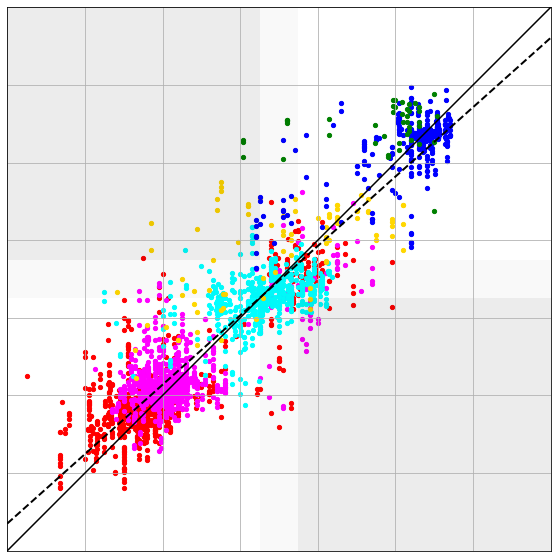

In [35]:
### Make plots
fig, ax = plt.subplots(figsize=(10, 10))
rf_result = all_result.copy()
a, b = np.polyfit(rf_result['Expt_pKa'], rf_result['pred_pka_an'], 1)
#rr = round(r2, 2)
plt.scatter(rf_result[rf_result['Res_Name'] == 'ASP']['Expt_pKa'], 
            rf_result[rf_result['Res_Name'] == 'ASP']['pred_pka_an'], color = 'red', s = 18, label = 'Asp')
plt.scatter(rf_result[rf_result['Res_Name'] == 'GLU']['Expt_pKa'],
            rf_result[rf_result['Res_Name'] == 'GLU']['pred_pka_an'], color = 'magenta', s = 18, label = 'Glu')
plt.scatter(rf_result[rf_result['Res_Name'] == 'HIS']['Expt_pKa'],
            rf_result[rf_result['Res_Name'] == 'HIS']['pred_pka_an'], color = 'cyan', s = 18, label = 'His')
plt.scatter(rf_result[rf_result['Res_Name'] == 'CYS']['Expt_pKa'],
            rf_result[rf_result['Res_Name'] == 'CYS']['pred_pka_an'], color = 'gold', s = 18, label = 'Cys')
plt.scatter(rf_result[rf_result['Res_Name'] == 'LYS']['Expt_pKa'],
            rf_result[rf_result['Res_Name'] == 'LYS']['pred_pka_an'], color = 'blue', s = 18, label = 'Lys')
plt.scatter(rf_result[rf_result['Res_Name'] == 'TYR']['Expt_pKa'],
            rf_result[rf_result['Res_Name'] == 'TYR']['pred_pka_an'], color = 'green', s = 18, label = 'Tyr')
plt.gca().set_aspect('equal', adjustable='box')
x = np.array([0, 14])
plt.plot(x, a*x+b, linestyle='--', linewidth=2, c = 'black')
plt.axvspan(xmin = 0, xmax = 6.5, ymin = 7.5/14, ymax = 1, color = 'k', alpha = 0.075, lw = 0)
plt.axvspan(xmin = 7.5, xmax = 14, ymin = 0, ymax = 6.5/14, color = 'k', alpha = 0.075, lw = 0)
plt.axvspan(xmin = 6.5, xmax = 7.5, color = 'k', alpha = 0.025, lw = 0)
plt.axvspan(xmin = 0, xmax = 6.5, ymin = 6.5/14, ymax = 7.5/14, color = 'k', alpha = 0.025, lw = 0)
plt.axvspan(xmin = 7.5, xmax = 14, ymin = 6.5/14, ymax = 7.5/14, color = 'k', alpha = 0.025, lw = 0)
plt.plot([0, 14], [0, 14], linestyle='solid', c = 'black')
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.grid()
#plt.legend(frameon = False, fontsize = 24)
plt.tick_params(bottom = False, left = False)
ax.tick_params(labelbottom = False)
ax.tick_params(labelleft = False)
plt.savefig(f'/home/rotation/mingzhe/his_pka/figs/GAT_split0to19_errorplot.svg')

# classification

In [22]:
def assig_cla(pka):
    if pka <= 6.5:
        pred_c = 'A'
    elif pka >= 7.5:
        pred_c = 'C'
    else:
        pred_c = 'B'
    return pred_c

def get_metrics(df):
    acc_prot = (len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) + len(df[(df['pred_c'] != 'C') & (df['pred_c'] != 'C')]))/len(df)
    acc_dep = (len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) + len(df[(df['pred_c'] != 'A') & (df['pred_c'] != 'A')]))/len(df)
    if len(df[df['pred_c'] == 'A']) > 0:
        prec_deprot = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) / len(df[df['pred_c'] == 'A']), 2)
    else:
        prec_deprot = float("nan")
    if len(df[df['expt_c'] == 'A']) > 0:
        reca_deprot = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) / len(df[df['expt_c'] == 'A']), 2)
    else:
        reca_deprot = float("nan")
    if len(df[df['pred_c'] == 'C']) > 0:
        prec_prot = round(len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) / len(df[df['pred_c'] == 'C']), 2)
    else:
        prec_prot = float("nan")
    if len(df[df['expt_c'] == 'C']) > 0:
        reca_prot = round(len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) / len(df[df['expt_c'] == 'C']), 2)
    else:
        reca_prot = float("nan")
    bad = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'C')]) + len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'A')]), 2)
    return prec_prot, reca_prot, prec_deprot, reca_deprot, bad, acc_prot, acc_dep

def get_metrics_notitr(df_all):
    ### exclude pred/expt as titrating class (B)
    df = df_all[(df_all['pred_c'] != 'B') & (df_all['expt_c'] != 'B')]
    if len(df) > 0:
        acc_prot = (len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) + len(df[(df['pred_c'] != 'C') & (df['pred_c'] != 'C')]))/len(df)
        acc_dep = (len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) + len(df[(df['pred_c'] != 'A') & (df['pred_c'] != 'A')]))/len(df)
    else:
        acc_prot = float("nan")
        acc_dep = float("nan") 
    if len(df[df['pred_c'] == 'A']) > 0:
        prec_deprot = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) / len(df[df['pred_c'] == 'A']), 2)
    else:
        prec_deprot = float("nan")
    if len(df[df['expt_c'] == 'A']) > 0:
        reca_deprot = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'A')]) / len(df[df['expt_c'] == 'A']), 2)
    else:
        reca_deprot = float("nan")
    if len(df[df['pred_c'] == 'C']) > 0:
        prec_prot = round(len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) / len(df[df['pred_c'] == 'C']), 2)
    else:
        prec_prot = float("nan")
    if len(df[df['expt_c'] == 'C']) > 0:
        reca_prot = round(len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'C')]) / len(df[df['expt_c'] == 'C']), 2)
    else:
        reca_prot = float("nan")
    bad = round(len(df[(df['pred_c'] == 'A') & (df['expt_c'] == 'C')]) + len(df[(df['pred_c'] == 'C') & (df['expt_c'] == 'A')]), 2)
    return prec_prot, reca_prot, prec_deprot, reca_deprot, bad, acc_prot, acc_dep

In [28]:
df_metrics = pd.DataFrame()
for n_expt in range(20):
    ensemble_li = make_ensamble(n_expt)
    rf_result = ensamble_result(n_expt, ensemble_li)
    add_restype(rf_result)
    anti_norm(rf_result, norm_dict[n_expt][0], norm_dict[n_expt][1])
    back_to_pka(rf_result)
    rf_result = drop_cphmd_cys(rf_result, n_expt)
    for index, row in rf_result.iterrows():
        pred_c = assig_cla(row['pred_pka_an'])
        expt_c = assig_cla(row['Expt_pKa'])
        rf_result.at[index, 'expt_c'] = expt_c
        rf_result.at[index, 'pred_c'] = pred_c
    
    prec_prot, reca_prot, prec_deprot, reca_deprot, bad, acc_prot, acc_dep = get_metrics_notitr(rf_result)
    prec_prot_d, reca_prot_d, prec_deprot_d, reca_deprot_d, bad_d, acc_d_prot, acc_d_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='ASP'])
    prec_prot_e, reca_prot_e, prec_deprot_e, reca_deprot_e, bad_e, acc_e_prot, acc_e_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='GLU'])
    prec_prot_h, reca_prot_h, prec_deprot_h, reca_deprot_h, bad_h, acc_h_prot, acc_h_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='HIS'])
    prec_prot_c, reca_prot_c, prec_deprot_c, reca_deprot_c, bad_c, acc_c_prot, acc_c_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='CYS'])
    prec_prot_y, reca_prot_y, prec_deprot_y, reca_deprot_y, bad_y, acc_y_prot, acc_y_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='TYR'])
    prec_prot_k, reca_prot_k, prec_deprot_k, reca_deprot_k, bad_k, acc_k_prot, acc_k_dep = get_metrics_notitr(rf_result[rf_result['Res_Name']=='LYS'])
    tmp_li = {'Expt':[n_expt], 'bad':[bad], 'acc_prot':[acc_prot], 'acc_dep':[acc_dep], 
              'prec_prot':[prec_prot],'reca_prot':[reca_prot],'prec_deprot':[prec_deprot],'reca_deprot':[reca_deprot],
              'prec_prot_d':[prec_prot_d],'reca_prot_d':[reca_prot_d], 
              'prec_dep_d':[prec_deprot_d],'reca_dep_d':[reca_deprot_d],
              'acc_d_prot':[acc_d_prot], 'acc_d_dep':[acc_d_dep], 
              'prec_prot_e':[prec_prot_e],'reca_prot_e':[reca_prot_e],
              'prec_dep_e':[prec_deprot_e],'reca_dep_e':[reca_deprot_e],
              'acc_e_prot':[acc_e_prot], 'acc_e_dep':[acc_e_dep], 
              'prec_prot_h':[prec_prot_h],'reca_prot_h':[reca_prot_h],
              'prec_dep_h':[prec_deprot_h],'reca_dep_h':[reca_deprot_h],
              'acc_h_prot':[acc_h_prot], 'acc_h_dep':[acc_h_dep], 
              'prec_prot_c':[prec_prot_c],'reca_prot_c':[reca_prot_c],
              'prec_dep_c':[prec_deprot_c],'reca_dep_c':[reca_deprot_c],
              'acc_c_prot':[acc_c_prot], 'acc_c_dep':[acc_c_dep], 
              'prec_prot_y':[prec_prot_y],'reca_prot_y':[reca_prot_y],
              'prec_dep_y':[prec_deprot_y],'reca_dep_y':[reca_deprot_y],
              'acc_y_prot':[acc_y_prot], 'acc_y_dep':[acc_y_dep], 
              'prec_prot_k':[prec_prot_k],'reca_prot_k':[reca_prot_k],
              'prec_dep_k':[prec_deprot_k],'reca_dep_k':[reca_deprot_k],
              'acc_k_prot':[acc_k_prot], 'acc_k_dep':[acc_k_dep], }
    tmp = pd.DataFrame(tmp_li)
    df_metrics = pd.concat([df_metrics, tmp], ignore_index = True)

In [34]:
df_metrics.loc['mean'] = df_metrics.head(20).mean()
df_metrics.loc['std'] = df_metrics.head(20).std()
df_metrics.loc['sum'] = df_metrics.head(20).sum()
df_metrics.round(2)

Expt    bad  acc_prot  acc_dep  prec_prot  reca_prot  prec_deprot  \
0       0.00   1.00      1.00     0.99       1.00       0.96         0.99   
1       1.00   2.00      0.99     0.99       0.92       0.92         0.99   
2       2.00   7.00      0.98     0.96       0.91       0.81         0.95   
3       3.00   4.00      0.98     0.98       0.89       0.89         0.98   
4       4.00   2.00      0.99     0.99       0.96       0.96         0.99   
5       5.00   3.00      0.98     0.99       0.91       0.95         0.99   
6       6.00   4.00      0.98     0.98       0.88       0.88         0.98   
7       7.00   1.00      1.00     0.99       1.00       0.96         0.99   
8       8.00   2.00      0.99     1.00       0.92       1.00         1.00   
9       9.00   4.00      0.97     1.00       0.83       1.00         1.00   
10     10.00   4.00      0.98     0.99       0.90       0.96         0.99   
11     11.00   5.00      0.97     0.98       0.84       0.89         0.98   
12     12.00   4.00      0.99     0.98       0.95       0.86         0.98   
13     13.00   1.00      1.00     0.99       1.00       0.97         0.99   
14     14.00   3.00      0.99     0.98       0.92       0.85         0.98   
15     15.00   5.00      0.99     0.98       0.94       0.91         0.97   
16     16.00   4.00      0.98     0.99       0.90       0.97         0.99   
17     17.00   3.00      0.98     0.99       0.90       0.95         0.99   
18     18.00   5.00      0.98     0.98       0.86       0.90         0.98   
19     19.00   6.00      0.99     0.96       0.95       0.80         0.96   
mean    9.50   3.50      0.99     0.99       0.92       0.92         0.98   
std     5.92   1.67      0.01     0.01       0.05       0.06         0.01   
sum   190.00  70.00     19.73    19.73      18.38      18.39        19.67   

      reca_deprot  prec_prot_d  reca_prot_d  prec_dep_d  reca_dep_d  \
0            1.00         1.00         1.00        1.00        1.00   
1            0.99          NaN          NaN        1.00        1.00   
2            0.98         1.00         1.00        1.00        1.00   
3            0.98          NaN         0.00        0.98        1.00   
4            0.99          NaN          NaN        1.00        1.00   
5            0.98          NaN          NaN        1.00        1.00   
6            0.98         1.00         1.00        1.00        1.00   
7            1.00          NaN          NaN        1.00        1.00   
8            0.98         1.00         1.00        1.00        1.00   
9            0.97          NaN          NaN        1.00        1.00   
10           0.97         1.00         1.00        1.00        1.00   
11           0.97         1.00         0.50        0.97        1.00   
12           0.99         1.00         1.00        1.00        1.00   
13           1.00         1.00         1.00        1.00        1.00   
14           0.99          NaN         0.00        0.97        1.00   
15           0.98          NaN         0.00        0.98        1.00   
16           0.98         0.50         1.00        1.00        0.98   
17           0.98          NaN          NaN        1.00        1.00   
18           0.97         1.00         1.00        1.00        1.00   
19           0.99         1.00         1.00        1.00        1.00   
mean         0.98         0.95         0.75        1.00        1.00   
std          0.01         0.15         0.43        0.01        0.00   
sum         19.67        10.50        10.50       19.90       19.98   

      acc_d_prot  acc_d_dep  prec_prot_e  reca_prot_e  prec_dep_e  reca_dep_e  \
0           1.00       1.00          1.0         1.00        1.00         1.0   
1           1.00       1.00          1.0         1.00        1.00         1.0   
2           1.00       1.00          1.0         0.50        0.98         1.0   
3           1.00       0.98          NaN          NaN        1.00         1.0   
4           1.00       1.00          NaN         

In [28]:
#df_metrics.to_csv('/home/rotation/mingzhe/his_pka/gnn_reg/clf_metrics.csv', index = False)

In [33]:
df_metrics.tail(2)

Expt       bad  acc_prot   acc_dep  prec_prot  reca_prot  \
mean  9.50000  3.500000  0.986357  0.986265   0.919000   0.919500   
std   5.91608  1.670172  0.008631  0.010281   0.048656   0.058443   

      prec_deprot  reca_deprot  prec_prot_d  reca_prot_d  prec_dep_d  \
mean     0.983500     0.983500     0.954545     0.750000    0.995000   
std      0.012258     0.009881     0.150756     0.427425    0.010513   

      reca_dep_d  acc_d_prot  acc_d_dep  prec_prot_e  reca_prot_e  prec_dep_e  \
mean    0.999000    0.998936   0.995580          1.0     0.522000    0.988000   
std     0.004472    0.004758   0.009252          0.0     0.402815    0.013219   

      reca_dep_e  acc_e_prot  acc_e_dep  prec_prot_h  reca_prot_h  prec_dep_h  \
mean         1.0         1.0   0.988710     0.250000     0.130769    0.916000   
std          0.0         0.0   0.012505     0.377964     0.298286    0.089643   

      reca_dep_h  acc_h_prot  acc_h_dep  prec_prot_c  reca_prot_c  prec_dep_c  \
mean    0.938500    0.942863   0.920020     0.580588     0.969167    0.846154   
std     0.099751    0.095304   0.082333     0.412772     0.077161    0.375534   

      reca_dep_c  acc_c_prot  acc_c_dep  prec_prot_y  reca_prot_y  prec_dep_y  \
mean    0.472222    0.698246   0.984211     0.933500          1.0         NaN   
std     0.436302    0.351579   0.050146     0.165506          0.0         NaN   

      reca_dep_y  acc_y_prot  acc_y_dep  prec_prot_k  reca_prot_k  prec_dep_k  \
mean         0.0    0.933333        1.0     0.970000          1.0         NaN   
std          0.0    0.165787        0.0     0.039068          0.0         NaN   

      reca_dep_k  acc_k_prot  acc_k_dep  
mean         0.0    0.970004        1.0  
std          0.0    0.039036        0.0